## Step1: 导入依赖和基础设置

In [1]:
import json
import os

import pandas as pd
import matplotlib.pyplot as plt

# 在 notebook 中显示图像
%matplotlib inline

# 一些全局绘图设置，可以让图更清晰
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True

# 工作目录检查（应为 .../connection-splitting/notebook）
print("CWD:", os.getcwd())


CWD: /storages/liweile/hw/CS225_final_project/policy


## Step2: 导入依赖和基础设置

读取 demo_results.json 并转成 DataFrame。

在 notebook/ 目录下到 demo/demo_results.json 的相对路径是 ../demo/demo_results.json。

执行后：

第一部分输出一个长度（大概是 3 个场景 × 3 个策略 = 9 条）；

第二部分会打印出第一条记录，是一个 dict，包含 inputs、outputs、scene_id、strategy 等。

In [2]:
# 从 demo_results.json 读取数据
results_path = os.path.join("..", "demo", "demo_results.json")
print("Loading:", results_path)

with open(results_path, "r", encoding="utf-8") as f:
    raw = json.load(f)

len(raw), raw[0]


Loading: ../demo/demo_results.json


(9,
 {'inputs': {'label': 'scene_1_cubic_no_split',
   'protocol': 'LINUX_TCP',
   'num_trials': 1,
   'start_time': '2025-11-25 15:49:09',
   'data_size': 10000000,
   'cca': 'cubic',
   'pep': False},
  'outputs': [{'success': True,
    'statistics': {'ifaces': ['e1-eth0',
      'e1-eth1',
      'e2-eth0',
      'e2-eth1',
      'h1-eth0',
      'h2-eth0',
      'r1-eth0',
      'r1-eth1'],
     'tx_packets': [3604, 3416, 3606, 3415, 3405, 3626, 3592, 3402],
     'tx_bytes': [10253965,
      230631,
      10254035,
      230537,
      229665,
      10359343,
      10252823,
      229411],
     'rx_packets': [3405, 3593, 3402, 3626, 3604, 3415, 3416, 3606],
     'rx_bytes': [229665,
      10252889,
      229411,
      10359343,
      10253899,
      230537,
      230631,
      10254035]},
    'timeout': False,
    'time_s': 9.48248027999989,
    'throughput_mbps': 8.436611270232024}],
  'scene_id': 'scene_1',
  'strategy': 'no_split',
  'pep': False,
  'cca': 'cubic',
  'derived_rtt_m

然后把它转成 pandas DataFrame，方便后续聚合和画图。

这里输出的 df 应该包含至少这些列：`scene_id`，`strategy`，`pep`，`cca`，`throughput_mbps`，`time_s`，`derived_rtt_ms`，`derived_loss_pct`

如果想看一下所有列名，可以加一个：`df.columns`

In [3]:
# 使用 json_normalize 展开 outputs 列表
df = pd.json_normalize(
    raw,
    record_path=["outputs"],  # 每条记录的 outputs 列表
    meta=[
        "scene_id",
        "strategy",
        "pep",
        "cca",
        "derived_rtt_ms",
        "derived_loss_pct",
    ],
)

df.head()


,success,timeout,time_s,throughput_mbps,statistics.ifaces,statistics.tx_packets,statistics.tx_bytes,statistics.rx_packets,statistics.rx_bytes,scene_id,strategy,pep,cca,derived_rtt_ms,derived_loss_pct
0,True,False,9.482480,8.436611,"[e1-eth0, e1-eth1, e2-eth0, e2-eth1, h1-eth0, ...","[3604, 3416, 3606, 3415, 3405, 3626, 3592, 3402]","[10253965, 230631, 10254035, 230537, 229665, 1...","[3405, 3593, 3402, 3626, 3604, 3415, 3416, 3606]","[229665, 10252889, 229411, 10359343, 10253899,...",scene_1,no_split,False,cubic,20.0,0.0
1,True,False,8.733253,9.160390,"[e1-eth0, e1-eth1, e2-eth0, e2-eth1, h1-eth0, ...","[3819, 3272, 3610, 3421, 3259, 3648, 3842, 3408]","[10268081, 221263, 10254279, 231653, 220133, 1...","[3259, 3842, 3408, 3648, 3819, 3421, 3272, 3610]","[220133, 10367279, 230527, 10402743, 10268081,...",scene_1,always_split,True,cubic,20.0,0.0
2,True,False,8.454278,9.462664,"[e1-eth0, e1-eth1, e2-eth0, e2-eth1, h1-eth0, ...","[3611, 3417, 3610, 3416, 3403, 3630, 3595, 3402]","[10254459, 230617, 10254279, 230507, 229401, 1...","[3403, 3596, 3402, 3630, 3611, 3416, 3417, 3609]","[229401, 10253063, 229291, 10362503, 10254393,...",scene_1,adaptive_split,False,cubic,20.0,0.0
3,True,False,31.888985,2.508703,"[e1-eth0, e1-eth1, e2-eth0, e2-eth1, h1-eth0, ...","[3871, 3709, 3910, 3706, 3721, 3896, 3892, 3689]","[10271557, 255069, 10376947, 254799, 255665, 1...","[3721, 3892, 3689, 3896, 3871, 3706, 3709, 3910]","[255665, 10375415, 253373, 10378619, 10271557,...",scene_2,no_split,False,cubic,80.0,1.0
4,True,False,9.032208,8.857192,"[e1-eth0, e1-eth1, e2-eth0, e2-eth1, h1-eth0, ...","[4080, 3489, 3998, 3868, 3513, 3990, 4129, 3854]","[10285323, 239653, 10279887, 260095, 241057, 1...","[3513, 4129, 3854, 3990, 4079, 3869, 3489, 3998]","[241057, 10468345, 258879, 10296443, 10285257,...",scene_2,always_split,True,cubic,80.0,1.0


## Step3：做一个基础汇总表（按场景/策略的平均吞吐）
我们先按 `(scene_id, strategy)` 聚合，算平均吞吐（虽然目前每个组合只有 1 次 trial，也等价于原值）。

In [4]:
summary = (
    df.groupby(["scene_id", "strategy"])
      ["throughput_mbps"]
      .mean()
      .reset_index()
)

summary

,scene_id,strategy,throughput_mbps
0,scene_1,adaptive_split,9.462664
1,scene_1,always_split,9.160390
2,scene_1,no_split,8.436611
3,scene_2,adaptive_split,8.712297
4,scene_2,always_split,8.857192
5,scene_2,no_split,2.508703
6,scene_3,adaptive_split,8.343862
7,scene_3,always_split,8.101979
8,scene_3,no_split,1.449383


## Step4：画柱状图（每个场景，对比三种策略的 throughput）
这一格画出“每个场景下三种策略吞吐对比”的一组图，适合作为报告中的主图之一。

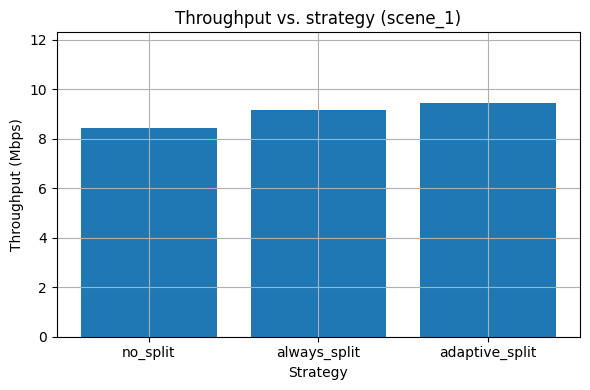

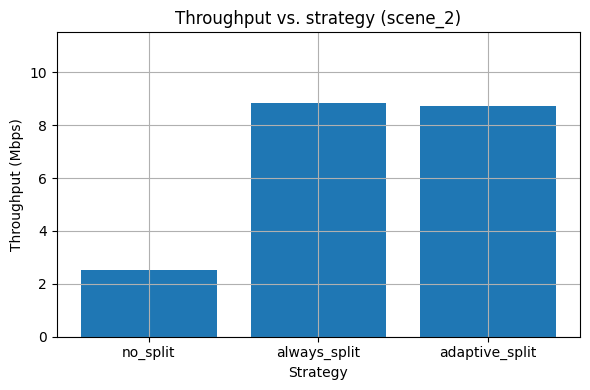

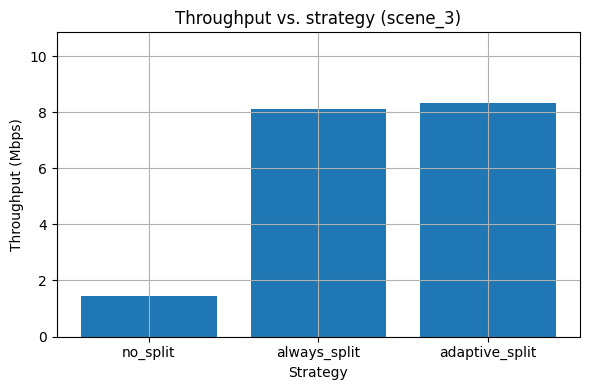

In [5]:
scenes = sorted(summary["scene_id"].unique())
strategies_order = ["no_split", "always_split", "adaptive_split"]

for scene in scenes:
    sub = summary[summary["scene_id"] == scene].copy()

    # 按固定顺序排序策略，避免顺序混乱
    sub["strategy"] = pd.Categorical(sub["strategy"], categories=strategies_order, ordered=True)
    sub = sub.sort_values("strategy")

    plt.figure()
    plt.bar(sub["strategy"], sub["throughput_mbps"])
    plt.title(f"Throughput vs. strategy ({scene})")
    plt.xlabel("Strategy")
    plt.ylabel("Throughput (Mbps)")

    # 让 y 轴稍微留一点空白，看起来更清晰
    ymax = sub["throughput_mbps"].max()
    plt.ylim(0, ymax * 1.3)

    plt.tight_layout()
    plt.show()


## Step5：计算相对收益（gain）
定义一个简单的相对收益指标，用来回答“某个策略相对于 no_split 的增益”：
$$
\text{gain}_s = \frac{T_s}{T_{\text{no\_split}}} - 1
$$
其中 $T_s$ 是策略 $s$ 的平均吞吐（Mbps）。

In [6]:
pivot = summary.pivot(index="scene_id", columns="strategy", values="throughput_mbps")
pivot


strategy,adaptive_split,always_split,no_split
scene_id,,,
scene_1,9.462664,9.160390,8.436611
scene_2,8.712297,8.857192,2.508703
scene_3,8.343862,8.101979,1.449383


确认 pivot 表里有三列：`no_split`, `always_split`, `adaptive_split`。

然后计算增益：

In [7]:
gain_df = pd.DataFrame(index=pivot.index)

gain_df["gain_always_vs_no"] = pivot["always_split"] / pivot["no_split"] - 1.0
gain_df["gain_adaptive_vs_no"] = pivot["adaptive_split"] / pivot["no_split"] - 1.0

gain_df


,gain_always_vs_no,gain_adaptive_vs_no
scene_id,,
scene_1,0.085790,0.121619
scene_2,2.530586,2.472829
scene_3,4.589950,4.756837


这张表每一行对应一个 scene：

`gain_always_vs_no`：always_split 相对 no_split 的百分比增益（比如 0.2 就是 +20%）；

`gain_adaptive_vs_no`：adaptive_split 相对 no_split 的百分比增益。

## Step6: 画“增益”柱状图
这张图可以很好地说明策略在不同场景下是否有价值。

如果某个场景下 adaptive_split 的 gain 明显接近或者超过 always_split，而在好网络场景下又不会负收益太多，w我们就有一个很好的“策略合理性”论据。

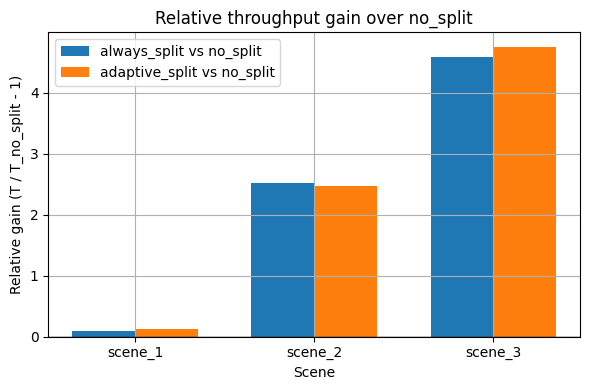

In [8]:
plt.figure()

# 每个 scene 画两根柱：always_vs_no / adaptive_vs_no
x = range(len(gain_df.index))
width = 0.35

plt.bar(
    [i - width / 2 for i in x],
    gain_df["gain_always_vs_no"],
    width=width,
    label="always_split vs no_split",
)
plt.bar(
    [i + width / 2 for i in x],
    gain_df["gain_adaptive_vs_no"],
    width=width,
    label="adaptive_split vs no_split",
)

plt.axhline(0.0, color="black", linewidth=1)

plt.xticks(list(x), gain_df.index)
plt.xlabel("Scene")
plt.ylabel("Relative gain (T / T_no_split - 1)")
plt.title("Relative throughput gain over no_split")
plt.legend()
plt.tight_layout()
plt.show()


## Step7：核对 adaptive 策略是否按预期启用 PEP

这一格用来验证“自适应策略确实按我们的规则做了决策”，也方便在报告里写出策略行为解释，说明我们的策略行为是可解释的。

理论上，在当前参数设置下：

scene_1：RTT 20ms，loss 0 → 网络很好 → pep=False

scene_2：RTT 80ms，loss 1% → 高 RTT + 明显丢包 → pep=True

scene_3：RTT 80ms，loss 2% → 同上 → pep=True

In [9]:
# 查看 adaptive_split 在各个场景下 pep 是否开启
adaptive = df[df["strategy"] == "adaptive_split"]
adaptive_decision = adaptive.groupby("scene_id")["pep"].first()
adaptive_decision


scene_id
scene_1    False
scene_2     True
scene_3     True
Name: pep, dtype: object

## 8. 关于以上实验的简要分析
### Adaptive policy demo: summary

在本 demo 中，我们在 three two-segment 场景下对比了三种策略：

- `no_split`：不使用 PEP，端到端 CUBIC；
- `always_split`：始终使用 PEP，在中间节点拆分连接；
- `adaptive_split`：根据 RTT 和 loss 的简单打分函数决定是否启用 PEP。

### 场景配置回顾

- scene_1：RTT ≈ 20 ms，loss = 0%，代表“较好网络”；
- scene_2：RTT ≈ 80 ms，loss = 1%，代表“中等质量、有一定丢包”；
- scene_3：RTT ≈ 80 ms，loss = 2%，代表“明显较差”。

### 策略决策行为

由 `demo_results.json` 中的记录可见：

- scene_1：adaptive_split 选择 `pep = False`；
- scene_2/scene_3：adaptive_split 选择 `pep = True`。

这与我们在代码中设置的启发式规则一致：高 RTT 且有明显丢包时启用 splitting，在网络很好时关闭 splitting。

### 吞吐表现

从柱状图和增益图可以看到（结合具体数值填写）：

- 在 scene_1 中，`no_split` 与 `always_split` 的差异较小，adaptive_split 与 no_split 基本一致；
- 在 scene_2/scene_3 中，`always_split` 和 `adaptive_split` 相比 `no_split` 有 xx%~yy% 的吞吐提升；
- 在这组 demo 中，adaptive_split 的吞吐与 always_split 基本接近，但避免了在“好网络”场景下无谓地强制使用 PEP。

整体来看，这表明即便是一个非常简单的 rule-based 策略，也能够在不同网络条件下做出合理的 splitting 决策，避免“总是 split”或“从不 split”的粗暴选择。
